In [1]:
import unittest
import scanpy as sc

import encoders
import decoders
import core
import latentspace
import training
import loader
import math
import anndata

import torch

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

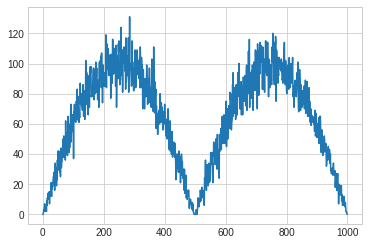

In [2]:
if False:
    ### Real data
    adata = sc.read("data/small_rna.h5ad")
else:
    ### Create artificial data to fit
    num_cell = 1000

    gene1 = [np.random.poisson(int(abs(100*math.sin(float(v)*2*math.pi/num_cell)))) for v in range(0,num_cell)]
    gene2 = [np.random.poisson(int(abs(100*math.cos(float(v)*2*math.pi/num_cell)))) for v in range(0,num_cell)]
    gene3 = [np.random.poisson(int(abs(100*math.sin(float(v)*math.pi/num_cell)))) for v in range(0,num_cell)]
    gene4 = [np.random.poisson(int(abs(100*math.cos(float(v)*math.pi/num_cell)))) for v in range(0,num_cell)]

    X=[gene1,gene2,gene3,gene4]
    adata=anndata.AnnData(np.array(X).T)

    plt.plot(gene1)

In [3]:
adata

AnnData object with n_obs × n_vars = 1000 × 4

In [4]:
mean_value = np.mean(gene1)
variance_value = np.var(gene1)
mean_value, variance_value

(63.929, 1022.355959)

In [5]:
print(adata.X.sum().mean())
print(adata.X.sum(-1).mean())
print(adata.X.sum(1).mean())

253923.0
253.923
253.923


CUDA is available: True
Chose device: 
------------------------ sizes of variables ---------------------
{'X': 4, 'X_sf': 3, 'enc_rna': 2, 'enc_sf': 2, 'sf_rna': 1, 'z': 1, 'rnaseq_count': 4}
---------------------- where variables are used as inputs -------
[('X', ['DVAEencoderFC', 'DVAEencoderFC']), ('enc_sf', ['DVAElatentspaceSizeFactor']), ('X_sf', ['DVAElatentspaceSizeFactor']), ('enc_rna', ['DVAElatentspaceLinear']), ('z', ['DVAEdecoderRnaseq'])]
---------------------- where variables are outputs --------------
[('X', 'DVAEloaderCounts'), ('X_sf', 'DVAEloaderCounts'), ('enc_rna', 'DVAEencoderFC'), ('enc_sf', 'DVAEencoderFC'), ('sf_rna', 'DVAElatentspaceSizeFactor'), ('z', 'DVAElatentspaceLinear'), ('rnaseq_count', 'DVAEdecoderRnaseq')]
-----------------------------------------------------------------
====== num params 18856
training DVAEtrainingBasic epoch 0 loss 11176.4404296875, in parts {'kl': 11147.732299804688, 'reconstruction': 28.70836067199707}
training DVAEtrainingBasic e

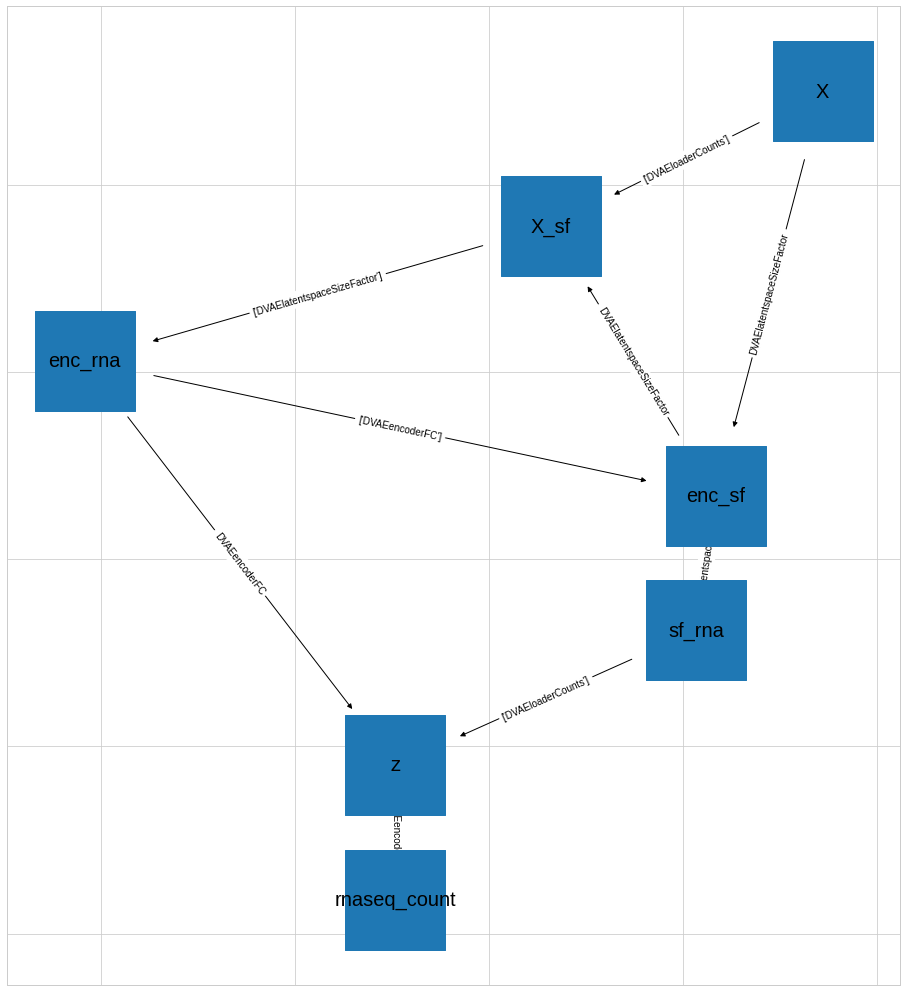

------------------------ connections ---------------------
    
      from            to                   edge_label
2        X        enc_sf    DVAElatentspaceSizeFactor
4        X          X_sf           [DVAEloaderCounts]
0     X_sf       enc_rna  [DVAElatentspaceSizeFactor]
1  enc_rna             z                DVAEencoderFC
7  enc_rna        enc_sf              [DVAEencoderFC]
3   enc_sf          X_sf    DVAElatentspaceSizeFactor
8   enc_sf        sf_rna      [DVAElatentspaceLinear]
5   sf_rna             z           [DVAEloaderCounts]
6        z  rnaseq_count              [DVAEencoderFC]


,from,to,edge_label
2,X,enc_sf,DVAElatentspaceSizeFactor
4,X,X_sf,[DVAEloaderCounts]
0,X_sf,enc_rna,[DVAElatentspaceSizeFactor]
1,enc_rna,z,DVAEencoderFC
7,enc_rna,enc_sf,[DVAEencoderFC]
3,enc_sf,X_sf,DVAElatentspaceSizeFactor
8,enc_sf,sf_rna,[DVAElatentspaceLinear]
5,sf_rna,z,[DVAEloaderCounts]
6,z,rnaseq_count,[DVAEencoderFC]


In [6]:
device = training.get_torch_device()

m = core.DVAEmodel(adata)

# rename to input
loader.DVAEloaderCounts(m)

if False:
    the_enc = encoders.DVAEencoderFC(m, inputs="X", output="enc_rna", n_output=4)
    zspace = latentspace.DVAElatentspaceLinear(m, inputs="enc_rna", output="z")
    the_dec = decoders.DVAEdecoderFC(m, inputs="z")
elif False:
    the_enc = encoders.DVAEencoderFC(m, inputs="X", output="enc_rna", n_output=2)
    the_dec = decoders.DVAEdecoderFC(m, inputs="enc_rna")
else:
    # encoder layer
    the_enc = encoders.DVAEencoderFC(m, inputs="X", output="enc_rna", n_output=2)
    the_enc_sf = encoders.DVAEencoderFC(m, inputs="X", output="enc_sf", n_output=2)

    # latent space
    the_l = latentspace.DVAElatentspaceSizeFactor(m, inputs="enc_sf", sf_empirical="X_sf", output="sf_rna")
    zspace = latentspace.DVAElatentspaceLinear(m, inputs="enc_rna", output="z")
    


    # RNA decoder
    the_dec = decoders.DVAEdecoderRnaseq(
            m,
            inputs="z",
            input_sf="sf_rna",
            gene_likelihood="poisson"  # "zinb"
        )

m.env.print_variable_defs()

trainer = training.DVAEtrainingBasic(num_epoch=500, lr = 1e-3)
epoch_losses, total_epoch_losses = trainer.train(m)

m.env.call_graph()

In [7]:
# print(the_l.get_latent_coordinates())
# print(zspace.get_latent_coordinates())

In [8]:
adata.X.max()

131.0

In [9]:
kl = [round(v) for k in total_epoch_losses for i,v in enumerate(k.values()) if i%2 == 0]
reconst = [round(v) for k in total_epoch_losses for i,v in enumerate(k.values()) if i%2 != 0]

Text(0.5, 0, 'epoch')

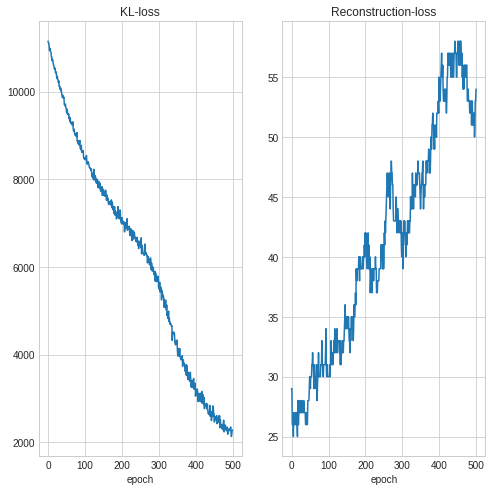

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.ticklabel_format(style = "plain")
plt.subplot(121)
plt.plot(range(0,len(kl)), kl)
plt.title("KL-loss")
plt.xlabel("epoch")
plt.subplot(122)
plt.plot(range(0,len(reconst)), reconst)
plt.title("Reconstruction-loss")
plt.xlabel("epoch")

In [11]:
# Prepare all data
dataset = m.get_dataset()
all_data = dataset[range(0,adata.shape[0])]
all_data = {k: torch.from_numpy(v) for k, v in all_data.items()}

# Predict. TODO forward and use means for latent spaces

with torch.no_grad():
    loss_recorder = m.forward(all_data, do_sampling=False)
    predicted_exp = m.env.get_variable_as_tensor("rnaseq_count").detach().cpu().numpy()
    predicted_l = m.env.get_variable_as_tensor("sf_rna").detach().cpu().numpy()
    

In [12]:
# np.exp(predicted_l)

In [13]:
predicted_exp.shape

(1000, 4)

In [14]:
loss_recorder._losses

{}

In [15]:
#adata = sc.read("data/small_rna.h5ad")

In [16]:
def pseudolog(x):
    return np.log(np.array(x)+1)

In [17]:
def todense(X):
    if hasattr(X,"todense"):
        return X.todense()
    else:
        return X

array([[1.        , 0.05038314],
       [0.05038314, 1.        ]])

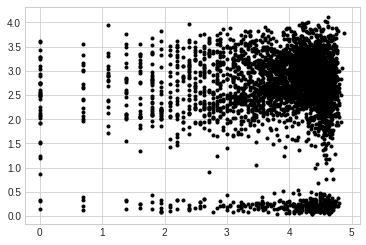

In [18]:
x = list(pseudolog(todense(adata.X[1:1000,]).flat))
y = list(pseudolog(predicted_exp[1:1000,].flat))
plt.plot(x, y, '.', color='black')
np.corrcoef(x,y)

In [19]:
adata.X.shape, predicted_exp.shape

((1000, 4), (1000, 4))

In [20]:
predicted_exp

array([[ 6.2041764 , 17.516537  ,  7.0498605 ,  7.8508224 ],
       [ 7.900969  , 18.229156  ,  5.7905145 ,  6.0831695 ],
       [ 6.1363487 , 14.456897  ,  6.883122  , 10.790908  ],
       ...,
       [10.232317  , 16.589622  ,  6.5536623 ,  5.06381   ],
       [ 0.14448524,  0.4401492 ,  0.16064438,  0.25472116],
       [14.6989355 , 11.024686  ,  7.363779  ,  5.358841  ]],
      dtype=float32)

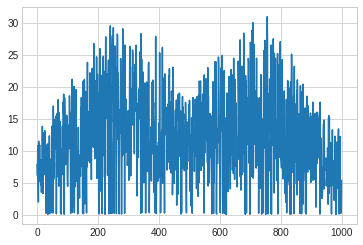

In [21]:
plt.plot(list((predicted_exp[:,3].flat)))


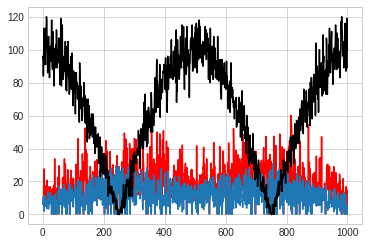

In [22]:
######## compare one gene vs prediction
x = list((todense(adata.X[:,1]).flat))
y1 = list((predicted_exp[:,0].flat))
y2 = list((predicted_exp[:,1].flat))
y3 = list((predicted_exp[:,2].flat))
y4 = list((predicted_exp[:,3].flat))
#plt.plot(x, y, 'o', color='black')
#np.corrcoef(x,y)
plt.plot(y1,'r')
# plt.plot(y2)
# plt.plot(y3)
plt.plot(y4)
plt.plot(x,'k')


array([[1.        , 0.00125302],
       [0.00125302, 1.        ]])

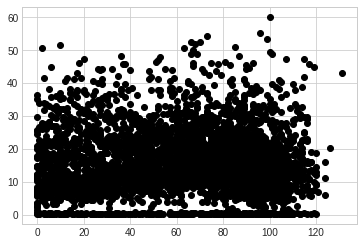

In [23]:
########### compare all genes
x = list((todense(adata.X[1:1000,]).flat))
y = list((predicted_exp[1:1000,].flat))
plt.plot(x, y, 'o', color='black')
np.corrcoef(x,y)

In [24]:
# sc.pl.umap(adata)
# https://github.com/YosefLab/scvi-tools/blob/master/scvi/train/_trainer.py


In [25]:
#z = zspace.get_latent_coordinates().detach().cpu().numpy()
z = m.env.get_variable_as_tensor("rnaseq_count")
# print(z)
z = z.detach().cpu().numpy()

In [26]:
# z

In [27]:
z[:,0].shape

(1000,)

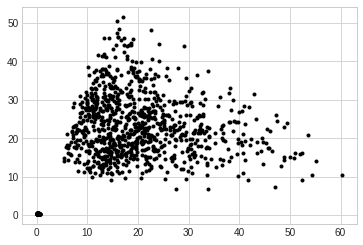

In [28]:
zx = z[:,0]
zy = z[:,1]
plt.plot(zx, zy, '.', color='black')

In [29]:
#the_enc.layer
#the_dec.layer
#m
the_enc.layer.linear_layers[0].weight

Parameter containing:
tensor([[ 0.0696,  0.0642, -0.2490,  0.1042],
        [-0.2312,  0.3477,  0.0719,  0.1338]], requires_grad=True)